# Project 8 - Predicting outcome of MMA fights

Les paris sportifs sont une industrie de plusieurs milliards de dollars. Sa popularité, tant sur le marché régional que mondial, en fait une activité très attrayante.
Les combats de MMA se classent parmi les meilleurs de l'industrie. Nous aimerions construire un modèle qui nous permettrait de prédire l'issue des combats de MMA, sur la base de données historiques. Le résultat idéal est un modèle qui peut à la fois prédire le vainqueur et donner une probabilité suffisamment élevée (>65-70%) pour ce résultat. De cette façon, nous pourrions également tirer parti des facteurs de risque lorsque nous décidons de parier selon le modèle ou contre lui.

Sports betting is a multibillion dollar industry. Its popularity both in regional and global market makes it a very attractive business.
Fighting ranks among the top in the industry. We would like to build a model that will allow us to predict the outcome of MMA fights, based on historical data. Ideal outcome is a model that can both predict the winner and give high enough probability (>65-70%) for this outcome. This way we could also leverage risk factors when deciding to bet according to the model or against it.

In [1]:
# libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 200)

workdir = 'C:/Users/aciag/Desktop/IDF OpenClassrooms/P8_Mykhailytskyi_Mykola' # instead of os module

from sklearn import preprocessing, decomposition, tree
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC

from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score, log_loss
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, plot_confusion_matrix

from yellowbrick.classifier import ClassificationReport

import shap

## EDA

In [2]:
# importation de données brutes
# raw data import
df = pd.read_csv(workdir + '/ufcdata/data.csv')
df.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_opp_KD,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_opp_PASS,B_avg_opp_REV,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_opp_SIG_STR_pct,B_avg_opp_SUB_ATT,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_opp_TD_pct,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_total_rounds_fought,B_total_time_fought(seconds),B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_BODY_att,R_avg_BODY_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_KD,R_avg_LEG_att,R_avg_LEG_landed,R_avg_PASS,R_avg_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_att,R_avg_TD_landed,R_avg_TD_pct,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_longest_win_streak,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0,4,0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.6,5.400000,0.400000,0.000000,65.40,22.600000,0.466000,0.400000,0.80000,0.200000,0.100000,66.400000,23.600000,4,1,6.400000,4.000000,1.000000,0.60000,51.200000,17.400000,0.600000,0.200000,39.600000,9.400000,0.200000,6.80000,4.800000,0.000000,0.000000,52.800000,18.20000,0.236000,0.000000,1.000000,0.400000,0.100000,53.800000,19.200000,9,419.400000,0,0,1,0,2,1,0,4,Orthodox,167.64,170.18,135.0,0,4,0,21.900000,16.400000,17.000000,11.000000,75.000000,26.500000,9.400000,6.500000,74.200000,23.90,0.400,5.300000,3.700000,1.200000,0.000000,101.400000,44.000000,0.466000,0.100000,5.300000,1.900000,0.458000,129.900000,69.100000,4,2,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27,742.60,3,0,2,4,2,0,0,8,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0,3,0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900000,112.000000,32.000000,0.000000,12.3,10.200000,0.800000,0.000000,138.90,51.300000,0.399000,0.7

In [3]:
df.shape

(5144, 145)

Le jeu de données contient plus de 5000 combats et un grand nombre de variables, 145.\
Cela pourrait compliquer la construction du modèle et la prédiction, donc l'une des premières choses que nous devons envisager est de réduire le nombre de colonnes.

Dataset contains more than 5000 fights and large number of variables, 145.
This might overcomplicate model-building and predicting, so one of the first things we need to consider is reducing number of columns.

In [4]:
print(df.date.min())
print(df.date.max())

1993-11-12
2019-06-08


L'ensemble de données décrit ~26 ans de combats, de 1993 à 2019.

Dataset describes ~26 years of fighting, from 1993 till 2019.

In [5]:
# Description des valeurs numériques dans notre jeu de données.
# Description of numerical values in our dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_rounds,5144.0,3.119362,0.631457,1.0,3.000000,3.000000,3.000000,5.00
B_current_lose_streak,5144.0,0.429821,0.731325,0.0,0.000000,0.000000,1.000000,6.00
B_current_win_streak,5144.0,0.837286,1.306203,0.0,0.000000,0.000000,1.000000,13.00
B_draw,5144.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00
B_avg_BODY_att,3879.0,8.689387,7.087703,0.0,3.500000,7.000000,12.225000,49.00
B_avg_BODY_landed,3879.0,6.083457,5.074464,0.0,2.333333,5.000000,8.500000,39.00
B_avg_CLINCH_att,3879.0,8.240461,7.575422,0.0,3.000000,6.333333,11.422222,87.00
B_avg_CLINCH_landed,3879.0,5.556352,5.429531,0.0,2.000000,4.200000,7.738636,68.00
B_avg_DISTANCE_att,3879.0,53.156807,41.252426,0.0,22.000000,44.666667,74.333333,271.00
B_avg_DISTANCE_landed,3879.0,19.329445,15.961112,0.0,7.666667,15.200000,27.142857,130.00


In [6]:
# vérifier les valeurs manquantes
# check for missing values
print((df.isna().sum()/df.shape[0]*100).round(2))
print(' ')
print(df.isna().sum())

R_fighter                        0.00
B_fighter                        0.00
Referee                          0.45
date                             0.00
location                         0.00
Winner                           0.00
title_bout                       0.00
weight_class                     0.00
no_of_rounds                     0.00
B_current_lose_streak            0.00
B_current_win_streak             0.00
B_draw                           0.00
B_avg_BODY_att                  24.59
B_avg_BODY_landed               24.59
B_avg_CLINCH_att                24.59
B_avg_CLINCH_landed             24.59
B_avg_DISTANCE_att              24.59
B_avg_DISTANCE_landed           24.59
B_avg_GROUND_att                24.59
B_avg_GROUND_landed             24.59
B_avg_HEAD_att                  24.59
B_avg_HEAD_landed               24.59
B_avg_KD                        24.59
B_avg_LEG_att                   24.59
B_avg_LEG_landed                24.59
B_avg_PASS                      24.59
B_avg_REV   

La vérification des valeurs manquantes nous montre que :
- 25 % des attributs des chasseurs bleus sont manquants
- 13% des attributs des combattants rouges sont manquants
- le nombre d'autres valeurs manquantes est faible

Missing values check show us that:
- 25% of attributes for Blue fighters are missing
- 13% of attributes for Red fighters are missing
- amount of other missing values is small

In [7]:
df.Winner.value_counts()

Red     3470
Blue    1591
Draw      83
Name: Winner, dtype: int64

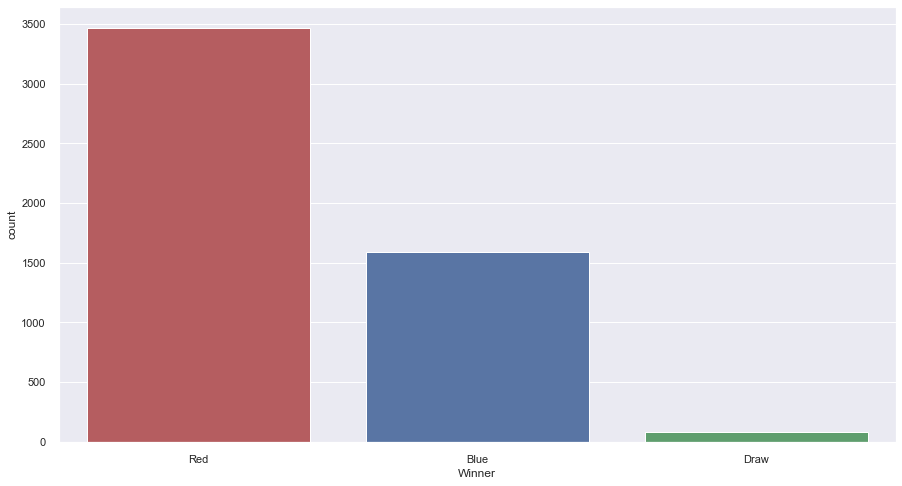

In [8]:
# visualisation des données initiales, distribution de la couleur gagnante
# viz of initial data, distribution of winning color

sns.set(style='darkgrid', color_codes=True, rc={'figure.figsize':(15,8)})
sns.countplot(data=df, x='Winner', palette={'Red':'r', 'Blue':'b', 'Draw':'g'}) # manual colorization

plt.show();

Notre variable dépendante souhaitée est fortement déséquilibrée.\
~70% des victoires sont pour les combattants rouges, et seulement 30% pour les bleus. Le nombre de tirages au sort est minuscule.\
Envisagez une distribution égale des gagnants pour les données du train (stratify=y pour sklearn ou class_weight).

Our desired dependable variable is highly imbalanced.\
~70% of wins are for Red fighters, and only 30% for Blue. Amount of draws is minuscule.\
Consider making equal destribution of winners for train data (stratify=y for sklearn or class_weight).

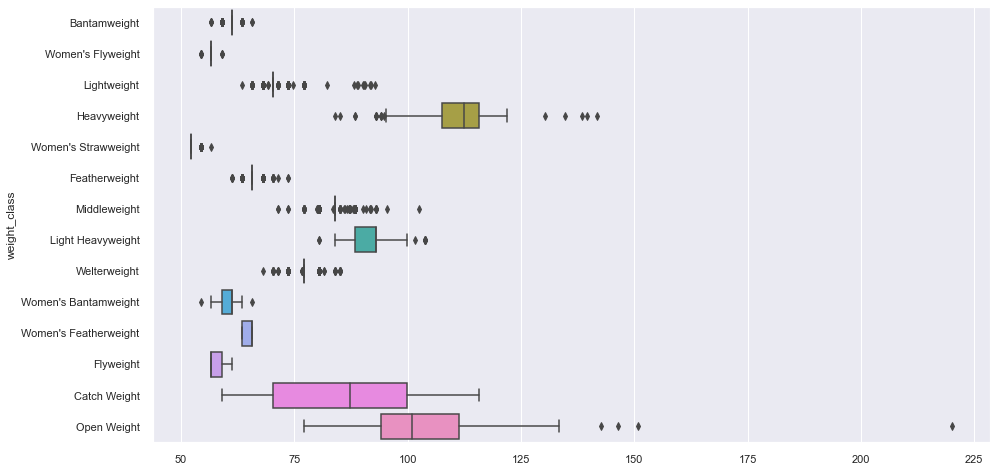

In [9]:
# montrer la distribution des poids pour chaque catégorie de poids, moyenne, en Kgs
# show distribution of weights per each weight category, average, in Kgs

sns.set(style='darkgrid', color_codes=True, rc={'figure.figsize':(15,8)})
sns.boxplot(data=df, y='weight_class', x=((df.R_Weight_lbs+df.B_Weight_lbs)/2 * 0.45359237))

plt.show();

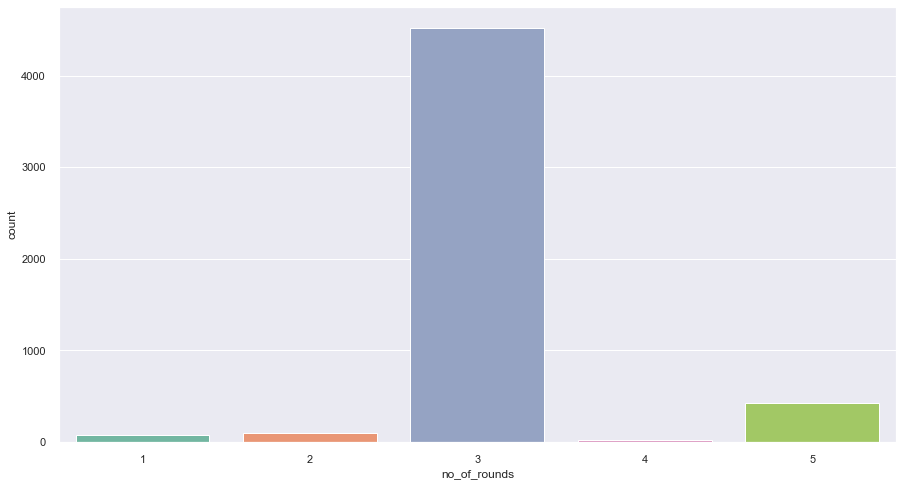

In [10]:
# Indiquer le nombre de tours pour déterminer le vainqueur.
# show amount of rounds to decide a winner

sns.set(style='darkgrid', color_codes=True, rc={'figure.figsize':(15,8)})
sns.countplot(data=df, x='no_of_rounds', palette='Set2')

plt.show();

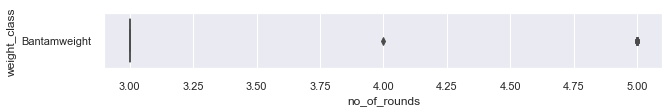

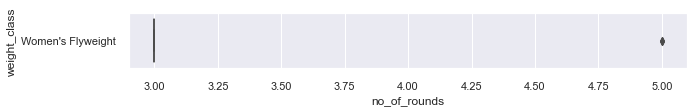

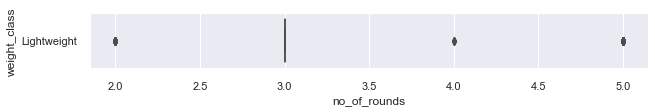

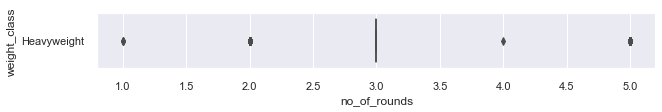

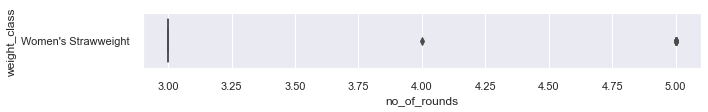

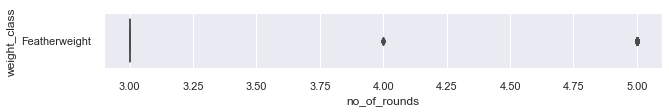

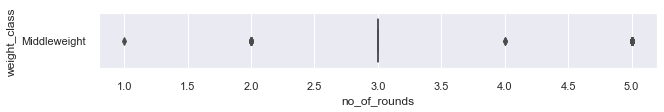

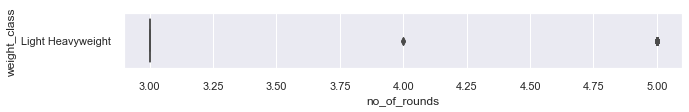

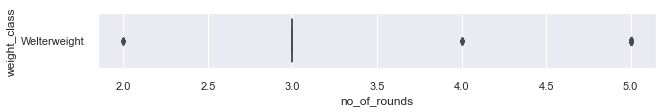

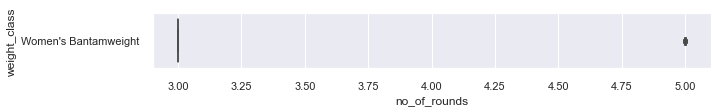

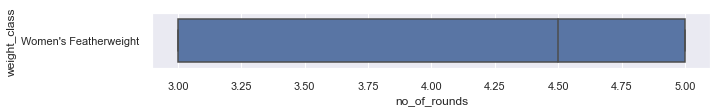

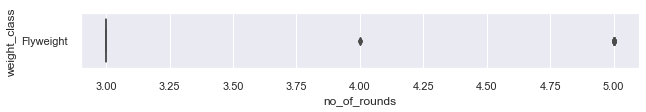

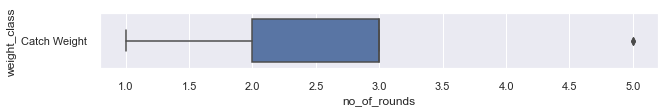

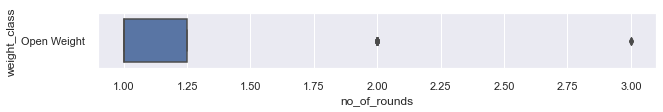

In [11]:
# boxplots des catégories de poids individuelles pour le nombre de rounds pour décider d'un gagnant.
# individual weight class boxplots for amount of rounds to decide a winner

sns.set(style='darkgrid', color_codes=True, rc={'figure.figsize':(10,1)})

for i in df['weight_class'].unique():
    sns.boxplot(data=df.loc[df['weight_class'] == i], x='no_of_rounds', y='weight_class')
    plt.show()

Dans la majorité des catégories de poids, il faut en moyenne trois rounds pour désigner un vainqueur.\
Les exceptions sont les poids ouverts (inférieurs à la moyenne) et les poids plumes féminins (supérieurs à la moyenne). 

Majority of weight classes on average take 3 rounds to decide a winner.\
Exceptions are open weight (lower than avg) and women's featherweight (higher than avg). 

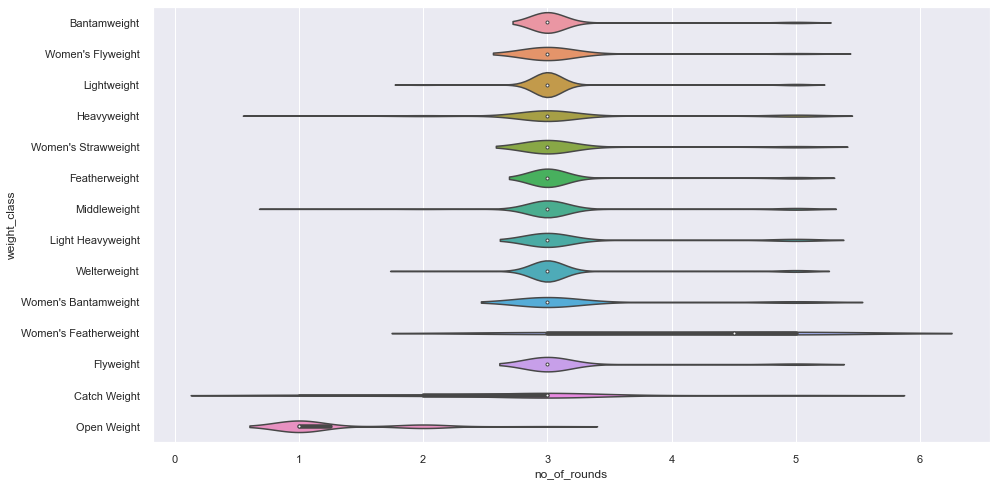

In [12]:
# montrer le nombre de tours pour décider d'un gagnant pour chaque catégorie de poids v2 (violin plot)
# show amount of rounds to decide a winner for each weight category v2 (violin plot)

sns.set(style='darkgrid', color_codes=True, rc={'figure.figsize':(15,8)})
sns.violinplot(data=df, x='no_of_rounds', y='weight_class')

plt.show();

### Cleaning and preprocessing

In [13]:
# supprimer tous les résultats de tirage de l'ensemble de données
# dropping all draw outcomes from the dataset
df.drop(df.loc[df['Winner']=='Draw'].index, inplace=True)

# Suppression des colonnes non pertinentes
# dropping irrelevant columns
df = df.drop(columns=['date'], axis=1)

# Suppression de toutes les lignes qui contiennent des NaN.
# drop all rows that have any NaN
df = df.dropna(axis=0, how='any')

# Réduction du nombre de colonnes de 145 à 30
# reduce amount of columns from 145 to 30
df = df[['Winner', 'title_bout', 'weight_class', 'Referee', 
         'B_fighter', 'B_current_lose_streak', 'B_current_win_streak', 
         'B_losses', 'B_total_rounds_fought', 'B_total_time_fought(seconds)', 'B_total_title_bouts',
         'B_wins', 'B_Stance', 'B_Height_cms', 'B_Reach_cms', 'B_Weight_lbs', 'B_age',
         'R_fighter', 'R_current_lose_streak', 'R_current_win_streak',
         'R_losses', 'R_total_rounds_fought', 'R_total_time_fought(seconds)',
         'R_total_title_bouts', 'R_wins', 'R_Stance', 'R_Height_cms', 'R_Reach_cms',
         'R_Weight_lbs', 'R_age']]

df.shape

(3151, 30)

Nous avons perdu ~2000 lignes en supprimant les NaNs. Nous avons réduit manuellement le nombre de colonnes (caractéristiques pour la modélisation) de 145 à 32. Les colonnes conservées correspondent aux données historiques que nous pouvons avoir avant que le combat n'ait lieu.

We lost ~2000 rows while removing NaNs. Manually reduced amount of columns (features for modelling) from 145 to 32. Columns kept correspond to historical data that we can have before the fight happens.

In [14]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151 entries, 0 to 5008
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Winner                        3151 non-null   object 
 1   title_bout                    3151 non-null   bool   
 2   weight_class                  3151 non-null   object 
 3   Referee                       3151 non-null   object 
 4   B_fighter                     3151 non-null   object 
 5   B_current_lose_streak         3151 non-null   int64  
 6   B_current_win_streak          3151 non-null   int64  
 7   B_losses                      3151 non-null   int64  
 8   B_total_rounds_fought         3151 non-null   int64  
 9   B_total_time_fought(seconds)  3151 non-null   float64
 10  B_total_title_bouts           3151 non-null   int64  
 11  B_wins                        3151 non-null   int64  
 12  B_Stance                      3151 non-null   object 
 13  B_H

In [15]:
# changer dtypes en type lisible par sklearn (string)
# change dtypes to sklearn-readable type (string)

le = preprocessing.LabelEncoder()

df.loc[:, ('Referee')] = df.loc[:, ('Referee')].astype('string')
df.loc[:, ('R_fighter')] = df.loc[:, ('R_fighter')].astype('string')
df.loc[:, ('B_fighter')] = df.loc[:, ('B_fighter')].astype('string')
df.loc[:, ('R_Stance')] = df.loc[:, ('R_Stance')].astype('string')
df.loc[:, ('B_Stance')] = df.loc[:, ('B_Stance')].astype('string')
df.loc[:, ('Winner')] = df.loc[:, ('Winner')].astype('string')
df.loc[:, ('weight_class')] = df.loc[:, ('weight_class')].astype('string')

# transformer les données non-numériques en données numériques (dummies)
# turn non-numeric data into numeric (dummies)
df['R_fighter'] = le.fit_transform(df['R_fighter'])
df['B_fighter'] = le.fit_transform(df['B_fighter'])
df['weight_class'] = le.fit_transform(df['weight_class'])
df['Referee'] = le.fit_transform(df['Referee'])
df['B_Stance'] = le.fit_transform(df['B_Stance'])
df['R_Stance'] = le.fit_transform(df['R_Stance'])
df['title_bout'] = le.fit_transform(df['title_bout'])

In [16]:
print(df.Winner.value_counts())
df['Winner'] = le.fit_transform(df['Winner']) # 1 RED, 0 BLUE
print(df.Winner.value_counts())

Red     2016
Blue    1135
Name: Winner, dtype: Int64
1    2016
0    1135
Name: Winner, dtype: int64


LabelEncoder a converti les valeurs dans la colonne Winner comme :\
    - Rouge est 1\
    - Bleu est 0

LabelEncoder converted values in Winner column as:\
    - Red is 1\
    - Blue is 0

In [17]:
# sauvegarder un petit sous-ensemble de données originales pour une validation future (nouvelle entrée)
# save a small subset of original data for future validation (new input)
validation_sample = df.sample(n=10) # can use frac=0.05 for 5% of data

# enlever ce que nous avons mis dans le sous-ensemble de l'original df
# remove what we put into subset from original df
df = df.loc[~df.index.isin(validation_sample.index)]

validation_sample

,Winner,title_bout,weight_class,Referee,B_fighter,B_current_lose_streak,B_current_win_streak,B_losses,B_total_rounds_fought,B_total_time_fought(seconds),B_total_title_bouts,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,B_age,R_fighter,R_current_lose_streak,R_current_win_streak,R_losses,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age
835,1,0,3,24,650,1,0,1,9,595.250000,0,3,1,172.72,175.26,125.0,31.0,556,2,0,2,2,245.500000,0,0,1,172.72,177.80,135.0,27.0
2120,1,0,5,42,395,4,0,7,24,567.454545,0,4,1,182.88,193.04,205.0,35.0,531,0,1,0,1,20.000000,0,1,1,185.42,190.50,253.0,29.0
4069,1,0,5,27,967,0,1,1,4,266.666667,0,2,1,182.88,187.96,185.0,28.0,360,0,1,0,2,474.000000,0,1,1,180.34,180.34,205.0,33.0
2209,0,0,8,38,748,0,4,2,18,735.000000,0,5,1,190.50,203.20,170.0,27.0,848,0,1,1,5,741.500000,1,1,1,180.34,190.50,170.0,23.0
2805,1,0,8,56,416,0,2,2,22,545.800000,0,8,1,175.26,180.34,170.0,28.0,707,0,4,1,13,605.666667,0,5,1,182.88,193.04,170.0,24.0
2357,0,0,3,107,295,0,1,1,9,866.333333,0,2,1,165.10,165.10,125.0,25.0,448,0,2,0,4,591.500000,0,2,2,170.18,167.64,125.0,22.0
3431,0,0,4,27,928,1,0,3,12,312.750000,0,5,1,210.82,213.36,265.0,23.0,633,1,0,3,11,439.500000,0,3,1,180.34,187.96,235.0,32.0
3533,1,0,7,56,968,1,0,1,8,534.750000,0,3,1,190.50,190.50,185.0,33.0,240,1,0,5,20,543.222222,1,4,1,185.42,195.58,205.0,30.0
1793,1,0,5,73,772,0,2,1,14,443.857143,0,6,2,190.50,203.20,205.0,32.0,297,2,0,2,16,620.857143,1,5,1,187.96,193.04,205.0,35.0
615,1,0,5,112,5,1,0,1,4,450.000000,0,1,1,190.50,193.04,205.0,30.0,418,0,2,0,6,900.000000,0,2,1,187.96,200.66,205.0,29.0


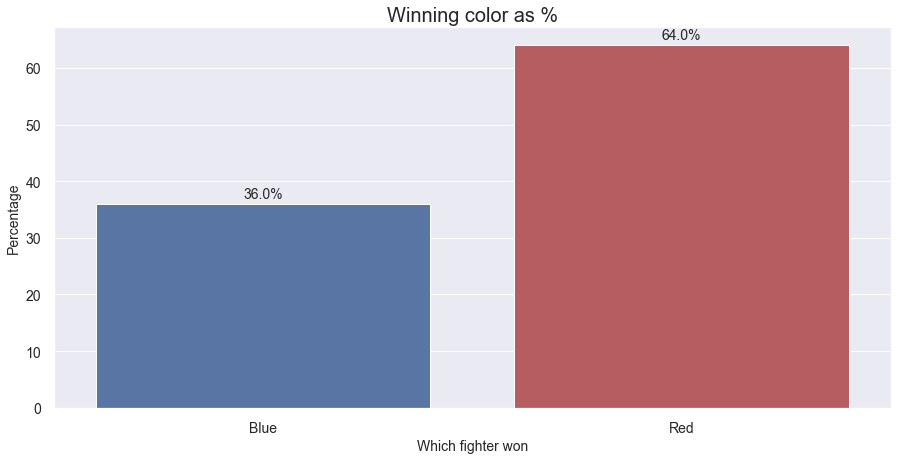

In [18]:
# Visualiser la couleur des gagnants (notre variable dépendante) sous forme de pourcentages.
# visualize winning color as percentages
norm_target = (df.Winner.value_counts(normalize=True).mul(100).rename('Winner').reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='Winner', data=norm_target, palette={1:'r', 0:'b'})

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)

plt.title('Winning color as %', fontsize=20)

plt.xlabel('Which fighter won', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xticklabels(['Blue', 'Red'])

plt.show();

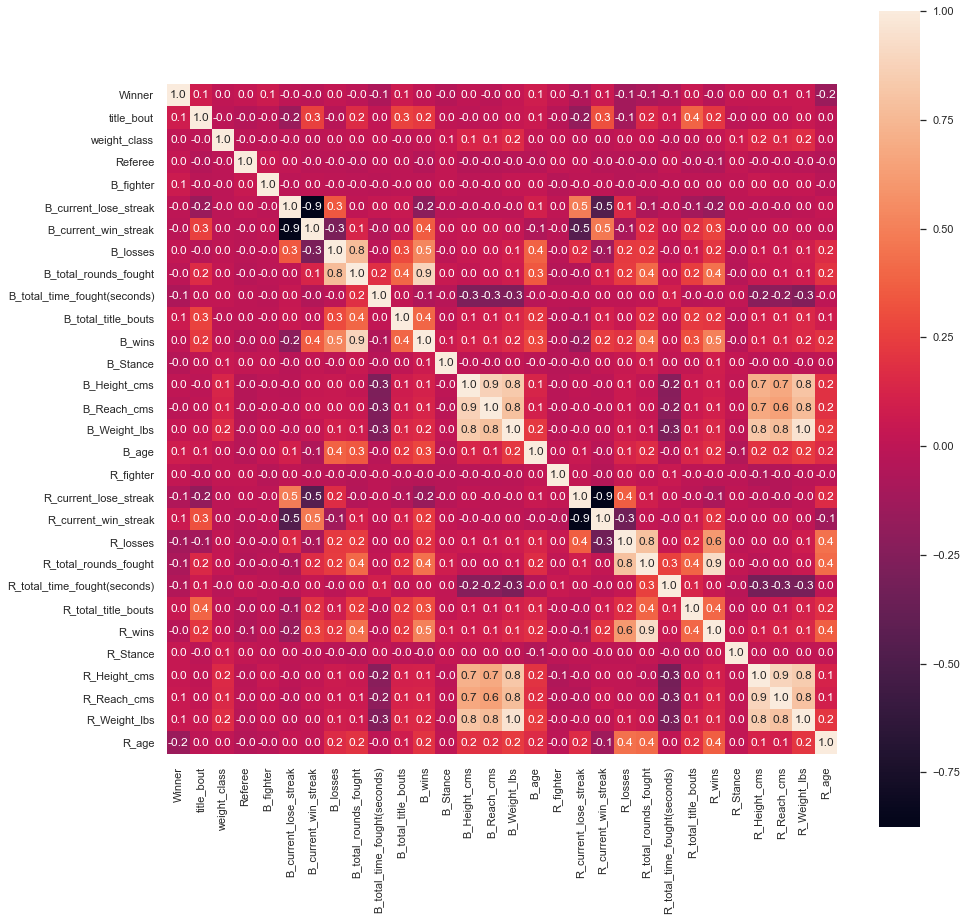

Wall time: 7.64 s


In [19]:
%%time

# Visualiser les corrélations dans nos données
# visualize correlations in our data

plt.figure(figsize=(15, 15))

sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".1f", square=True)
plt.savefig(fname=f'Correlations_heatmap.jpg', dpi=300, format='jpg', orientation='landscape', bbox_inches='tight')

plt.show();

## Building predictive models

Afin de trouver le(s) meilleur(s) modèle(s) pour notre objectif, nous nous tournons vers la documentation de scikit-learn:\
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html \
In order to find the best model(s) for our objective, we turn towards scikit-learn documentation

<img src="https://scikit-learn.org/stable/_static/ml_map.png" alt="alt text" title="image Title" width="1000"/>

Selon ce modèle, notre jeu de données et notre objectif exigent des modèles de classification comme étant les plus optimaux.\
Modèles de classification :
- Naive Bayes gaussien
- KNN (K Nearest Neighbors classifier)
- SVC
- Classificateur Random Forest
- Classificateur Decision Trees\
Nous pouvons également essayer d'appliquer d'autres types de modèles, à des fins d'expérimentation.

According to it, our dataset and our objective are calling for classification models as the most optimal ones.\
Classification models:
- Gaussian Naive Bayes
- KNN (K Nearest Neighbors classifier)
- SVC
- Random Forest classifier
- Decision Trees classifier\
We can also try and apply other types of models, for the sake of experimentation.

### Preprocessing and data split with standardization

In [20]:
# paramètres constants pour ce projet
# constant parameters for this project

TEST_SIZE = 0.33
RANDOM_STATE = 42

In [21]:
# diviser le cadre de données en données de formation et de test
# split dataframe into train and test data

X = df.drop('Winner', axis=1)
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, shuffle=True, random_state=RANDOM_STATE)

# Standardize X data. We leave Y as it is since it is a boolean variable
sc = preprocessing.StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)

### Model building and evaluation

In [22]:
# Logistic Regression

lr = LogisticRegression(max_iter = 2000)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(lr, X_train_norm, y_train.values.ravel(), cv=kfold)

print('Logistic Regression K-fold Scores (training):')
print(cv_score)
print('')
print('Logistic Regression Average Score:')
print(cv_score.mean())

Logistic Regression K-fold Scores (training):
[0.66350711 0.66350711 0.7014218  0.65402844 0.63809524 0.62857143
 0.63809524 0.64761905 0.71428571 0.63333333]

Logistic Regression Average Score:
0.6582464454976303


In [23]:
# Gaussian Naive Bayes

gnb = GaussianNB()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(gnb, X_train_norm, y_train.values.ravel(), cv=kfold)

print('Gaussian Naive Bayes K-fold Scores:')
print(cv_score)
print('')
print('Gaussian Naive Bayes Average Score:')
print(cv_score.mean())

Gaussian Naive Bayes K-fold Scores:
[0.52606635 0.52606635 0.66350711 0.56872038 0.54761905 0.5
 0.55238095 0.6        0.54761905 0.53333333]

Gaussian Naive Bayes Average Score:
0.556531257052584


In [24]:
# Decision Trees

dt = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(dt, X_train_norm, y_train.values.ravel(), cv=kfold)

print('Decision Tree K-fold Scores:')
print(cv_score)
print('')
print('Decision Tree Average Score:')
print(cv_score.mean())

Decision Tree K-fold Scores:
[0.51658768 0.58293839 0.55924171 0.56872038 0.55714286 0.55238095
 0.56190476 0.53809524 0.63333333 0.55714286]

Decision Tree Average Score:
0.5627488151658767


In [25]:
# KNN

knn = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(knn, X_train_norm, y_train.values.ravel(), cv=kfold)

print('KNN K-fold Scores):')
print(cv_score)
print()
print('KNN Average Score:')
print(cv_score.mean())

KNN K-fold Scores):
[0.61611374 0.58293839 0.65402844 0.59241706 0.58571429 0.58571429
 0.57142857 0.62380952 0.57619048 0.6047619 ]

KNN Average Score:
0.59931166779508


In [26]:
# Random Forests

rf = RandomForestClassifier(random_state=RANDOM_STATE)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(rf, X_train_norm, y_train.values.ravel(), cv=kfold)

print('Random Forest K-fold Scores:')
print(cv_score)
print('')
print('Random Forest Average Score:')
print(cv_score.mean())

Random Forest K-fold Scores:
[0.61137441 0.63981043 0.63507109 0.63507109 0.61428571 0.61904762
 0.64761905 0.64285714 0.67142857 0.60952381]

Random Forest Average Score:
0.6326088918979915


In [27]:
# SVC

svc = SVC(probability=True)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(svc, X_train_norm, y_train.values.ravel(), cv=kfold)

print('Support Vector Classification K-fold Scores:')
print(cv_score)
print('')
print('Support Vector Classification Average Score:')
print(cv_score.mean())

Support Vector Classification K-fold Scores:
[0.65402844 0.68720379 0.67298578 0.67298578 0.61904762 0.65238095
 0.66666667 0.65714286 0.69047619 0.63333333]

Support Vector Classification Average Score:
0.6606251410516814


### Testing best-performing models

D'après le score moyen de validation croisée, les modèles les plus performants sont la régression logistique, la forêt aléatoire et le svc.

Judging by average cross validation score, top performing models are logistic regression, random forest and svc.

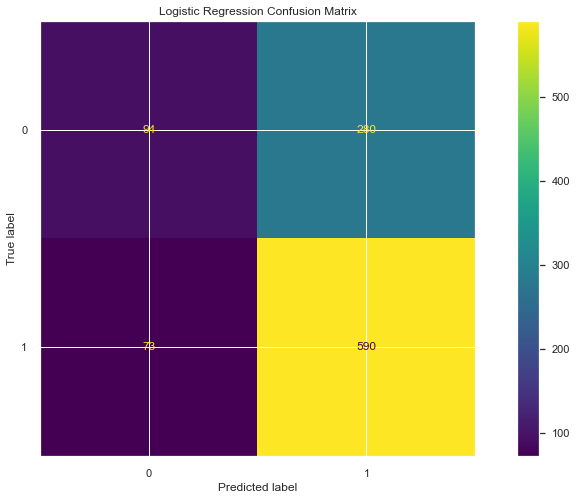

Logistic Regression model scores:
accuracy: 0.6595949855351977
precision: 0.6781609195402298
recall: 0.889894419306184


In [28]:
lr = LogisticRegression(max_iter = 2000)
lr_model = lr.fit(X_train_norm, y_train.values.ravel())
y_pred = lr_model.predict(X_test_norm)

disp = plot_confusion_matrix(lr_model, X_test_norm, y_test)
disp.ax_.set_title('Logistic Regression Confusion Matrix')

plt.show();

print('Logistic Regression model scores:')
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

In [29]:
# créer un cadre de données pour garder tous les scores en un seul endroit
# create a dataframe to keep all scores in one place

metrics = pd.DataFrame(index=['accuracy_score', 'precision_score', 'recall_score'])

metrics['LogReg_std'] = [accuracy_score(y_test, y_pred),
                        precision_score(y_test, y_pred),
                        recall_score(y_test, y_pred)]

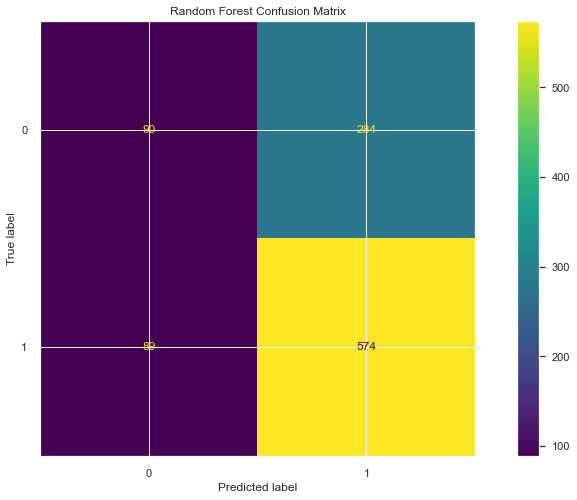

Random Forest model scores:
accuracy: 0.6403085824493732
precision: 0.668997668997669
recall: 0.8657616892911011


In [30]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model = rf.fit(X_train_norm, y_train.values.ravel())
y_pred = rf_model.predict(X_test_norm)
disp = plot_confusion_matrix(rf_model, X_test_norm, y_test)
disp.ax_.set_title('Random Forest Confusion Matrix')

plt.show();

print('Random Forest model scores:')
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

metrics['RandomForest_std'] = [accuracy_score(y_test, y_pred),
                        precision_score(y_test, y_pred),
                        recall_score(y_test, y_pred)]

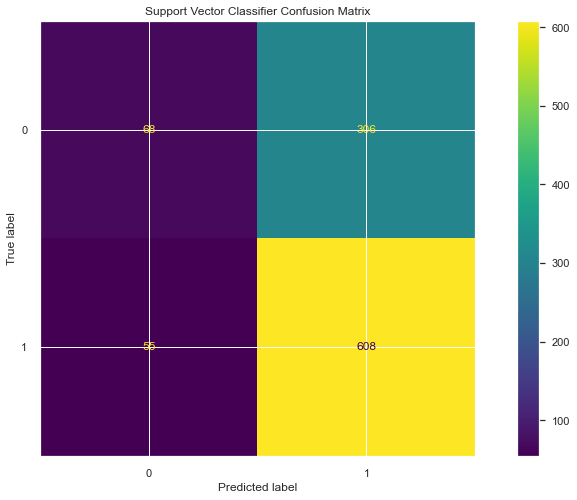

SVC model scores:
accuracy: 0.6518804243008679
precision: 0.6652078774617067
recall: 0.9170437405731523


In [31]:
svc = SVC(probability = True)
svc_model = svc.fit(X_train_norm, y_train.values.ravel())
y_pred = svc_model.predict(X_test_norm)
disp = plot_confusion_matrix(svc_model, X_test_norm, y_test)
disp.ax_.set_title('Support Vector Classifier Confusion Matrix')

plt.show();

print('SVC model scores:')
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

metrics['SVC_std'] = [accuracy_score(y_test, y_pred),
                        precision_score(y_test, y_pred),
                        recall_score(y_test, y_pred)]

In [32]:
metrics.T.style.highlight_max(color='blue')

,accuracy_score,precision_score,recall_score
LogReg_std,0.659595,0.678161,0.889894
RandomForest_std,0.640309,0.668998,0.865762
SVC_std,0.651880,0.665208,0.917044


Logistic Regression is top performing model, with 0.66% accuracy, top precision and 2nd recall.

## Predicting on validation_sample

In [33]:
# delete winner col from our validation sample
df_new = validation_sample.iloc[:, 1:]

In [34]:
print('Logistic Regression predicts the following winners:')
print(lr_model.predict(df_new))
print(validation_sample.Winner.values)
print('Actual fight results')

Logistic Regression predicts the following winners:
[1 1 1 1 1 0 1 1 1 0]
[1 1 1 0 1 0 0 1 1 1]
Actual fight results


In [35]:
print('Accuracy score for Logistic Regression on new data is', accuracy_score(validation_sample.Winner.values, lr_model.predict(df_new)))
print('Precision score for Logistic Regression on new data is', precision_score(validation_sample.Winner.values, lr_model.predict(df_new)))
print('Recall score for Logistic Regression on new data is', recall_score(validation_sample.Winner.values, lr_model.predict(df_new)))

Accuracy score for Logistic Regression on new data is 0.7
Precision score for Logistic Regression on new data is 0.75
Recall score for Logistic Regression on new data is 0.8571428571428571


In [36]:
print('RandomForest predicts the following winners:')
print(rf_model.predict(df_new))
print(validation_sample.Winner.values)
print('Actual fight results')

RandomForest predicts the following winners:
[1 0 0 1 0 0 1 0 0 0]
[1 1 1 0 1 0 0 1 1 1]
Actual fight results


In [37]:
print('Accuracy score for RandomForest on new data is', accuracy_score(validation_sample.Winner.values, rf_model.predict(df_new)))
print('Precision score for RandomForest on new data is', precision_score(validation_sample.Winner.values, rf_model.predict(df_new)))
print('Recall score for RandomForest on new data is', recall_score(validation_sample.Winner.values, rf_model.predict(df_new)))

Accuracy score for RandomForest on new data is 0.2
Precision score for RandomForest on new data is 0.3333333333333333
Recall score for RandomForest on new data is 0.14285714285714285


In [38]:
print('SVC predicts the following winners:')
print(svc_model.predict(df_new))
print(validation_sample.Winner.values)
print('Actual fight results')

SVC predicts the following winners:
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 0 0 1 1 1]
Actual fight results


In [39]:
print('Accuracy score for SVC on new data is', accuracy_score(validation_sample.Winner.values, svc_model.predict(df_new)))
print('Precision score for SVC on new data is', precision_score(validation_sample.Winner.values, svc_model.predict(df_new)))
print('Recall score for SVC on new data is', recall_score(validation_sample.Winner.values, svc_model.predict(df_new)))

Accuracy score for SVC on new data is 0.7
Precision score for SVC on new data is 0.7
Recall score for SVC on new data is 1.0


Conclusions sur les modèles avec des données standardisées :
- aucun des 3 modèles les plus performants ne semble bon.
- les 3 sont inconsistants, de 0,0 à 0,9 de précision. La moyenne se situe à 0,5.
- les modèles actuels ne nous permettent pas de les utiliser pour prédire les combats.
Nous devrions essayer d'entraîner les mêmes modèles sur des données originales, non standardisées.

Conclusions about models with standardized data:
- neither of 3 top performing models look good.
- all 3 are inconsistent, from 0.0 to 0.9 accuracy. Averaging at 0.5.
- current models do not allow us to use them in predicting fights.
We should try training the same models on original, non-standardized data.

### Preprocessing and data split on original data

In [40]:
# paramètres constants pour ce projet
# constant parameters for this project

TEST_SIZE = 0.33
RANDOM_STATE = 42

In [41]:
# diviser le cadre de données en données de formation et de test
# split dataframe into train and test data

X = df.drop('Winner', axis=1)
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, shuffle=True, random_state=RANDOM_STATE)

### Model building and evaluation

In [42]:
# Logistic Regression

lr = LogisticRegression(max_iter = 2000)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(lr, X_train, y_train.values.ravel(), cv=kfold)

print('Logistic Regression K-fold Scores (training):')
print(cv_score)
print('')
print('Logistic Regression Average Score:')
print(cv_score.mean())

Logistic Regression K-fold Scores (training):
[0.6492891  0.65402844 0.70616114 0.66350711 0.65714286 0.65714286
 0.63333333 0.63333333 0.7047619  0.63809524]

Logistic Regression Average Score:
0.6596795305800045


In [43]:
# Gaussian Naive Bayes

gnb = GaussianNB()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(gnb, X_train, y_train.values.ravel(), cv=kfold)

print('Gaussian Naive Bayes K-fold Scores:')
print(cv_score)
print('')
print('Gaussian Naive Bayes Average Score:')
print(cv_score.mean())

Gaussian Naive Bayes K-fold Scores:
[0.52606635 0.52606635 0.66350711 0.56872038 0.54761905 0.5
 0.55714286 0.6        0.54761905 0.53333333]

Gaussian Naive Bayes Average Score:
0.5570074475287745


In [44]:
# Decision Trees

dt = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(dt, X_train, y_train.values.ravel(), cv=kfold)

print('Decision Tree K-fold Scores:')
print(cv_score)
print('')
print('Decision Tree Average Score:')
print(cv_score.mean())

Decision Tree K-fold Scores:
[0.507109   0.58293839 0.56398104 0.56872038 0.55714286 0.55238095
 0.56666667 0.54285714 0.63333333 0.55714286]

Decision Tree Average Score:
0.5632272624689685


In [45]:
# KNN

knn = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(knn, X_train, y_train.values.ravel(), cv=kfold)

print('KNN K-fold Scores):')
print(cv_score)
print()
print('KNN Average Score:')
print(cv_score.mean())

KNN K-fold Scores):
[0.56872038 0.55450237 0.50236967 0.56398104 0.59047619 0.51428571
 0.54285714 0.5952381  0.51904762 0.51904762]

KNN Average Score:
0.5470525840668021


In [46]:
# Random Forests

rf = RandomForestClassifier(random_state=RANDOM_STATE)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(rf, X_train, y_train.values.ravel(), cv=kfold)

print('Random Forest K-fold Scores:')
print(cv_score)
print('')
print('Random Forest Average Score:')
print(cv_score.mean())

Random Forest K-fold Scores:
[0.61137441 0.64454976 0.63033175 0.62085308 0.60952381 0.61904762
 0.64285714 0.64285714 0.66190476 0.6047619 ]

Random Forest Average Score:
0.6288061385691718


In [47]:
# SVC

svc = SVC(probability=True)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_score = cross_val_score(svc, X_train, y_train.values.ravel(), cv=kfold)

print('Support Vector Classification K-fold Scores:')
print(cv_score)
print('')
print('Support Vector Classification Average Score:')
print(cv_score.mean())

Support Vector Classification K-fold Scores:
[0.63981043 0.63981043 0.63981043 0.63981043 0.63809524 0.63809524
 0.63809524 0.63809524 0.64285714 0.64285714]

Support Vector Classification Average Score:
0.6397336944256375


### Testing best-performing models

Une fois encore, les modèles les plus performants sont la régression logistique, la forêt aléatoire et le svc.

Once again, top performing models are logistic regression, random forest and svc.

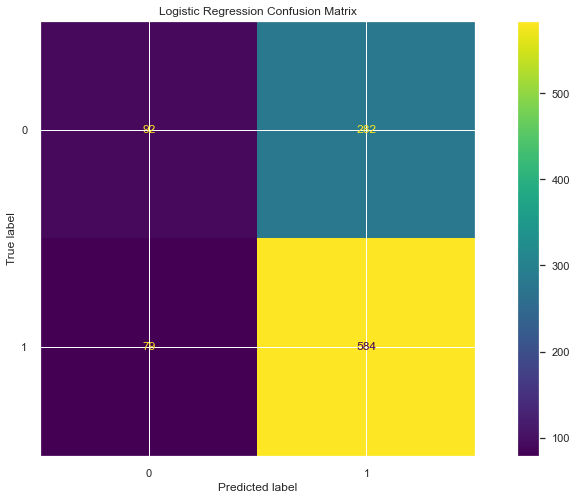

Logistic Regression model scores:
accuracy: 0.6518804243008679
precision: 0.674364896073903
recall: 0.8808446455505279


In [48]:
lr = LogisticRegression(max_iter = 2000)
lr_model = lr.fit(X_train, y_train.values.ravel())
y_pred = lr_model.predict(X_test)

disp = plot_confusion_matrix(lr_model, X_test, y_test)
disp.ax_.set_title('Logistic Regression Confusion Matrix')

plt.show();

print('Logistic Regression model scores:')
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

metrics['LogReg'] = [accuracy_score(y_test, y_pred),
                        precision_score(y_test, y_pred),
                        recall_score(y_test, y_pred)]

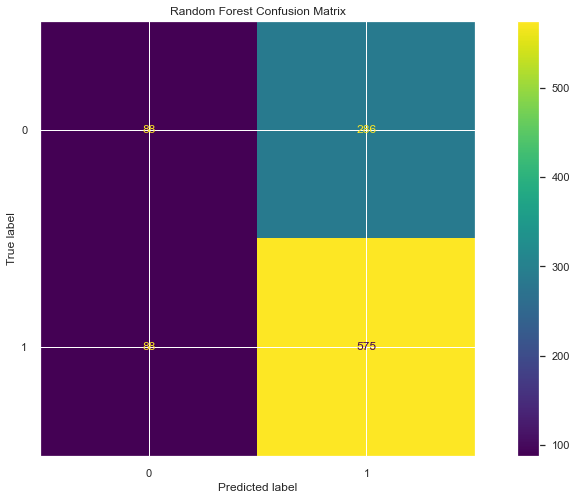

Random Forest model scores:
accuracy: 0.639344262295082
precision: 0.667828106852497
recall: 0.8672699849170438


In [49]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
disp = plot_confusion_matrix(rf_model, X_test, y_test)
disp.ax_.set_title('Random Forest Confusion Matrix')

plt.show()

print('Random Forest model scores:')
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

metrics['RandomForest'] = [accuracy_score(y_test, y_pred),
                        precision_score(y_test, y_pred),
                        recall_score(y_test, y_pred)]

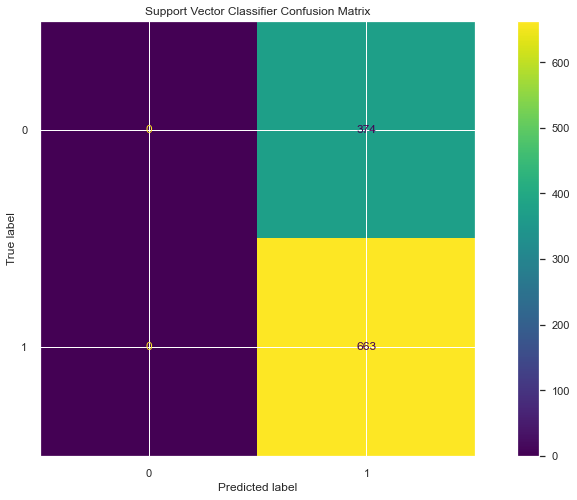

SVC model scores:
accuracy: 0.639344262295082
precision: 0.639344262295082
recall: 1.0


In [50]:
svc = SVC(probability = True)
svc_model = svc.fit(X_train, y_train.values.ravel())
y_pred = svc_model.predict(X_test)
disp = plot_confusion_matrix(svc_model, X_test, y_test)
disp.ax_.set_title('Support Vector Classifier Confusion Matrix')

plt.show();

print('SVC model scores:')
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

metrics['SVC'] = [accuracy_score(y_test, y_pred),
                        precision_score(y_test, y_pred),
                        recall_score(y_test, y_pred)]

In [51]:
metrics.T.style.highlight_max(color='blue')

,accuracy_score,precision_score,recall_score
LogReg_std,0.659595,0.678161,0.889894
RandomForest_std,0.640309,0.668998,0.865762
SVC_std,0.651880,0.665208,0.917044
LogReg,0.651880,0.674365,0.880845
RandomForest,0.639344,0.667828,0.867270
SVC,0.639344,0.639344,1.000000


Les scores ne sont pas uniformes, mais la plupart du temps, la régression logistique obtient les meilleurs scores pour les trois types de mesures.

Scores are inconsistent, but most of the time Logistic Regression has the best scores across 3 types of metrics.

## Predicting on validation_sample

In [52]:
print('Logistic Regression predicts the following winners:')
print(lr_model.predict(df_new))
print(validation_sample.Winner.values)
print('Actual fight results')

Logistic Regression predicts the following winners:
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 0 0 1 1 1]
Actual fight results


In [53]:
print('Accuracy score for Logistic Regression on new data is', accuracy_score(validation_sample.Winner.values, lr_model.predict(df_new)))
print('Precision score for Logistic Regression on new data is', precision_score(validation_sample.Winner.values, lr_model.predict(df_new)))
print('Recall score for Logistic Regression on new data is', recall_score(validation_sample.Winner.values, lr_model.predict(df_new)))

Accuracy score for Logistic Regression on new data is 0.7
Precision score for Logistic Regression on new data is 0.7
Recall score for Logistic Regression on new data is 1.0


In [54]:
print('RandomForest predicts the following winners:')
print(rf_model.predict(df_new))
print(validation_sample.Winner.values)
print('Actual fight results')

RandomForest predicts the following winners:
[1 1 1 1 1 1 1 1 1 0]
[1 1 1 0 1 0 0 1 1 1]
Actual fight results


In [55]:
print('Accuracy score for RandomForest on new data is', accuracy_score(validation_sample.Winner.values, rf_model.predict(df_new)))
print('Precision score for RandomForest on new data is', precision_score(validation_sample.Winner.values, rf_model.predict(df_new)))
print('Recall score for RandomForest on new data is', recall_score(validation_sample.Winner.values, rf_model.predict(df_new)))

Accuracy score for RandomForest on new data is 0.6
Precision score for RandomForest on new data is 0.6666666666666666
Recall score for RandomForest on new data is 0.8571428571428571


In [56]:
print('SVC predicts the following winners:')
print(svc_model.predict(df_new))
print(validation_sample.Winner.values)
print('Actual fight results')

SVC predicts the following winners:
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 0 0 1 1 1]
Actual fight results


In [57]:
print('Accuracy score for SVC on new data is', accuracy_score(validation_sample.Winner.values, svc_model.predict(df_new)))
print('Precision score for SVC on new data is', precision_score(validation_sample.Winner.values, svc_model.predict(df_new)))
print('Recall score for SVC on new data is', recall_score(validation_sample.Winner.values, svc_model.predict(df_new)))

Accuracy score for SVC on new data is 0.7
Precision score for SVC on new data is 0.7
Recall score for SVC on new data is 1.0


Conclusions sur les modèles avec des données non standardisées :
- la différence entre les scores est très faible, mais aussi incohérente. Les scores des modèles basés sur les données originales sont parfois légèrement supérieurs, parfois légèrement inférieurs.
- Il semble que l'entraînement sur les données originales donne des prédictions plus cohérentes.
- nous pourrions avoir besoin d'évaluer la capacité à voir quelle caractéristique (colonne) a plus de valeur pour le modèle, par rapport aux autres.

Conclusions about models with non-standardized data:
- difference in scores is very small, but also inconsistent. Sometimes scores from original data models are slightly higher, sometimes slightly lower.
- it seems that training on original data makes for a more consistent predictions.
- we might need to evaluate ability to see which feature (column) has more value for the model, compared to others.

### Weights of individual features

Nous utiliserons la bibliothèque SHAP.\
SHAP (SHapley Additive exPlanations) est une approche de la théorie des jeux pour expliquer la sortie de tout modèle d'apprentissage automatique. Elle relie l'allocation optimale de crédits aux explications locales en utilisant les valeurs de Shapley classiques de la théorie des jeux et leurs extensions connexes.

We will use SHAP library.\
SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

In [58]:
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.LinearExplainer.html
explainer = shap.LinearExplainer(lr, X_train, feature_dependence="independent")
shap_values = explainer(X_test)

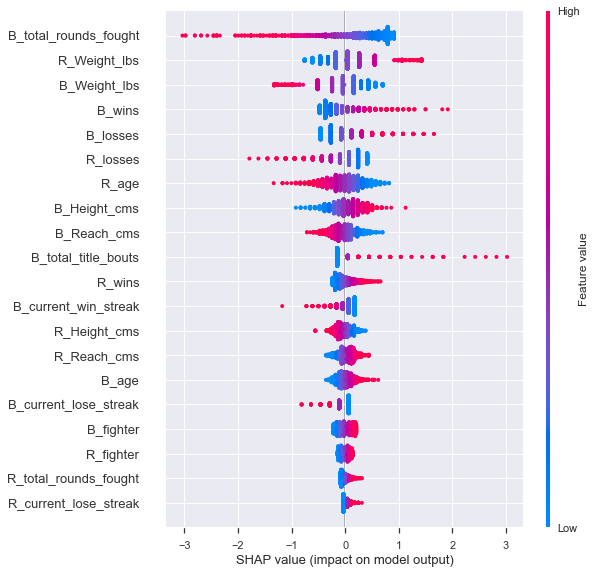

In [59]:
# summary plot
shap.summary_plot(shap_values, X_test)

FR:\
Les caractéristiques sont triées en fonction de leur impact, du plus fort au plus faible. C'est l'axe Y.\
L'axe X correspond aux valeurs SHAP. Chaque point est une observation distincte.\
Le code couleur aide à comprendre la signification de la caractéristique correspondante. Le bleu est faible, le rouge est élevé (ceci n'est pas du tout lié à notre variable dépendante du gagnant rouge-bleu).

Par exemple :
- si la caractéristique B_total_rounds_fought est plus élevée, il est plus probable que le combattant bleu gagne.
- si R_total_title_bouts est plus élevé, le combattant rouge a de fortes chances de gagner.
- si B_reach_cms devient élevé, le combattant bleu a plus de chances de gagner ; s'il devient faible, le combattant rouge a plus de chances de gagner.

ENG:\
Features are sorted by their impact, from highest to lowest. This is axis Y.\
Axis X is SHAP values. Each dot is a separate observation.\
Color-coding helps understand the meaning of corresponding feature. Blue is low, Red is high (this is not at all connected to our dependable variable of Red\Blue winner).

For example:
- if B_total_rounds_fought feature gets higher, most likely blue fighter will win.
- if R_total_title_bouts gets higher, most likely red fighter will win.
- if B_reach_cms gets high, blue fighter is more likely to win; if it gets low, red fighter is more likely to win.

We can compare SHAP library weights to coefficients of LogisticRegression itself.

In [60]:
# créer un tableau de coefficients de caractéristiques à partir de LogReg lui-même
# create a table of feature coefficients from LogReg itself

feature_imp = pd.DataFrame()
feature_imp['feature'] = X.columns
feature_imp['importance'] = lr.coef_[0]
feature_imp = feature_imp.sort_values(by='importance', ascending=False)

feature_imp

,feature,importance
0,title_bout,0.300566
9,B_total_title_bouts,0.198133
6,B_losses,0.192262
10,B_wins,0.103904
17,R_current_lose_streak,0.068166
23,R_wins,0.044520
24,R_Stance,0.042993
15,B_age,0.036126
12,B_Height_cms,0.035041
11,B_Stance,0.030437


## Conclusions générales

Étonnamment, le modèle le plus performant en termes de score s'est avéré être la régression logistique. Il est suivi de peu par Random Forest et SVC.
Cependant, les résultats des trois modèles les plus performants sont incohérents. Cela ne répond pas à notre objectif d'avoir une précision de 65-70%.
En gardant cela à l'esprit, afin d'utiliser notre (nos) modèle(s), nous devrions travailler davantage au perfectionnement de nos modèles. Sinon, l'utilisation de nos modèles existants serait très risquée.

Améliorations possibles pour ce projet :
- envisager de donner plus de poids aux données récentes, car elles devraient mieux refléter les combats d'aujourd'hui que les données de 1993.
- Essayer d'utiliser toutes les colonnes/fonctionnalités existantes. Nous pouvons essayer de déduire divers paramètres historiques pour chaque combattant qui pourraient aider aux prédictions.
- égaliser l'échantillon de validation pour avoir 50% de gagnants rouges et 50% de gagnants bleus.
- essayer d'autres types de modèles (XGBoost, etc).
- construire une meilleure représentation des prédictions (code de couleur, nom du combattant, etc.).
- construire une meilleure façon de montrer la confiance du modèle dans une prédiction spécifique.
- penser à présenter à l'utilisateur un ensemble de facteurs les plus précieux pour la prédiction.
- créer une interface conviviale (déploiement sur le web).


ENG:\
General conclusions

Surprisingly, the best performing model by score turned out to be Logistic Regression. Only slightly behind it is Random Forest and SVC.
However, the results of all 3 top performing models are inconsistent. This does not meet our goal of having 65-70% accuracy.
With this in mind, in order to use our model(s), we should put in more work towards perfecting our models. Otherwise using our existing models would be very risky.

Possible improvements for this project:
- look into giving more weight to recent data, since it should reflect modern day fights better than data from 1993.
- try and make use of all existing columns/features. We can try and deduce various historical parameters for each fighter that might help with predictions.
- equalize validation sample to have 50% Red and 50% Blue winners.
- try other types of models (XGBoost, etc).
- build a better representation of predictions (color coding, name of the fighter, etc).
- build a better way of showing how confident the model is in one specific prediction.
- think about presenting a user with a set of most valuable factors for prediction.
- create a user-friendly interface (web-deployment).